In [1]:
from pathlib import Path
import numpy as np
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
import sys
sys.path.append('/home/<User>/repos/csg_is')

from py_dataset import sys_func
from py_dataset import feature_plotting

In [3]:
file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data_ngrams.npz')
assert file_path.exists(), 'Data not found'

In [4]:
data_path = Path(
    "/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/"
)
assert data_path.exists()
vocab_file = data_path / "vocabulary_ngrams.pkl"

if vocab_file.exists():
    with open(str(vocab_file), "rb") as f:
        vocabulary = pickle.load(f)

    print("Loaded set:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

Loaded set: ('accept', 'accept4', 'access', 'add_key', 'adjtimex', 'bind', 'brk', 'capget', 'capset', 'chdir', 'chmod', 'chown32', 'clock_gettime', 'clone', 'close', 'connect', 'dup', 'dup2', 'dup3', 'epoll_create1', 'epoll_ctl', 'epoll_wait', 'eventfd2', 'execve', 'exit', 'exit_group', 'faccessat', 'fadvise64_64', 'fallocate', 'fchdir', 'fchmod', 'fchmodat', 'fchown32', 'fcntl64', 'fgetxattr', 'flistxattr', 'flock', 'fsetxattr', 'fstat64', 'fstatat64', 'fstatfs64', 'fsync', 'ftruncate64', 'futex', 'getcwd', 'getdents64', 'getegid32', 'geteuid32', 'getgid32', 'getgroups32', 'getpeername', 'getpgid', 'getpgrp', 'getpid', 'getppid', 'getpriority', 'getrandom', 'getresgid32', 'getresuid32', 'getsid', 'getsockname', 'getsockopt', 'gettid', 'gettimeofday', 'getuid32', 'getxattr', 'inotify_add_watch', 'ioctl', 'ioprio_get', 'ioprio_set', 'kcmp', 'keyctl', 'kill', 'lchown32', 'lgetxattr', 'llseek', 'lseek', 'lstat64', 'madvise', 'mkdir', 'mknod', 'mmap2', 'mount', 'mprotect', 'mremap', 'msync

In [5]:
with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

['arr_0']
(11428, 12882)
(12882,)


In [6]:
df.head(1)

,accept,accept4,access,add_key,adjtimex,bind,brk,capget,capset,chdir,...,utimensat write,utimensat writev,wait4 waitid,wait4 write,wait4 writev,waitid write,waitid writev,write writev,timestamp,label
0,0.0,0.000024,0.000491,0.0,0.0,0.000005,0.000605,0.000017,0.0,0.000006,...,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,0.0,1.699632e+09,4_bashlite


#### Plots

In [7]:
vectors = df.iloc[:, :-2]
vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=[])

df_scaled = vectors_scaled.copy()
df_scaled['label'] = df['label']
df_scaled['timestamp'] = df['timestamp']

###### Merged over Labels

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 80))
sns.boxplot(data=vectors, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 80))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

##### Split into labels

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(54, 3, figsize=(24, 220))

axs = axs.flatten()


for i, column in enumerate(df.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(54, 3, figsize=(24, 220))

axs = axs.flatten()


for i, column in enumerate(df_scaled.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df_scaled, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()

### Testing PCA

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize a list to store the explained variance ratios
explained_variance_ratios = []

# Perform PCA in several rounds, varying the number of components
for n_components in range(1, 11):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X[:, :-2])
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

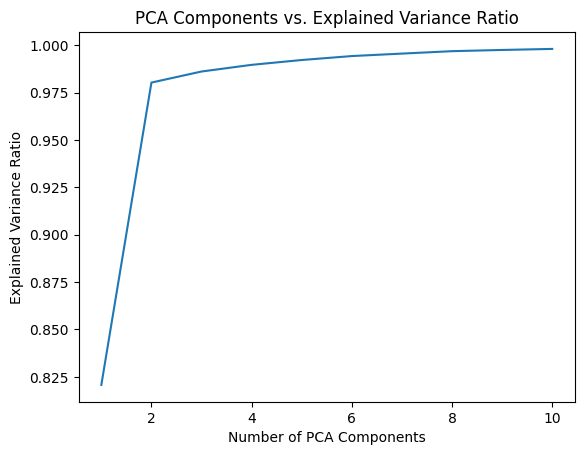

In [9]:
# Plot the explained variance ratios
plt.plot(range(1, 11), explained_variance_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components vs. Explained Variance Ratio')
plt.show()

In [11]:
explained_variance_ratios, X[:, :-2].shape

([0.8207281422529156,
  0.9802580429202932,
  0.9860967383205396,
  0.9896165832991104,
  0.9921669963813516,
  0.9942496163448531,
  0.9955489104754002,
  0.9968275355959796,
  0.9974708001019182,
  0.9980152515519916],
 (11428, 12880))

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:, :-2])
print(pca.explained_variance_ratio_.sum())
X_pca.shape

0.9802580429202938


(11428, 2)

In [13]:
X_pca = np.column_stack((X_pca, X[:, -2:]))
X_pca.shape

(11428, 4)

In [14]:
df_pca = pd.DataFrame(X_pca, columns=['pca1','pca2', 'timestamp', 'label'])

label_encoder = sys_func.create_label_encoder_for_labels()
df_pca['label'] = label_encoder.inverse_transform(df_pca['label'].values.astype(int))

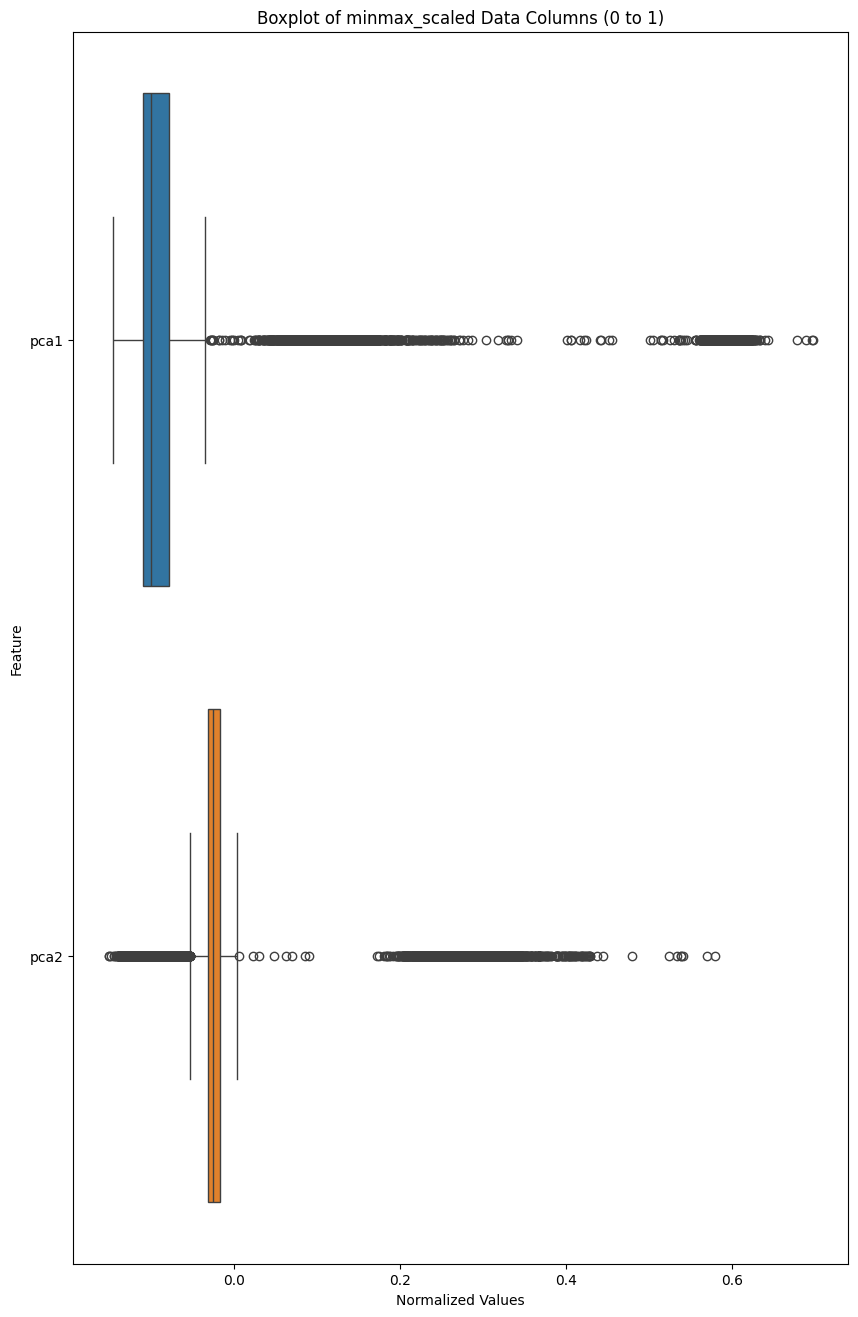

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 16))
sns.boxplot(data=df_pca.iloc[:, :-2], native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

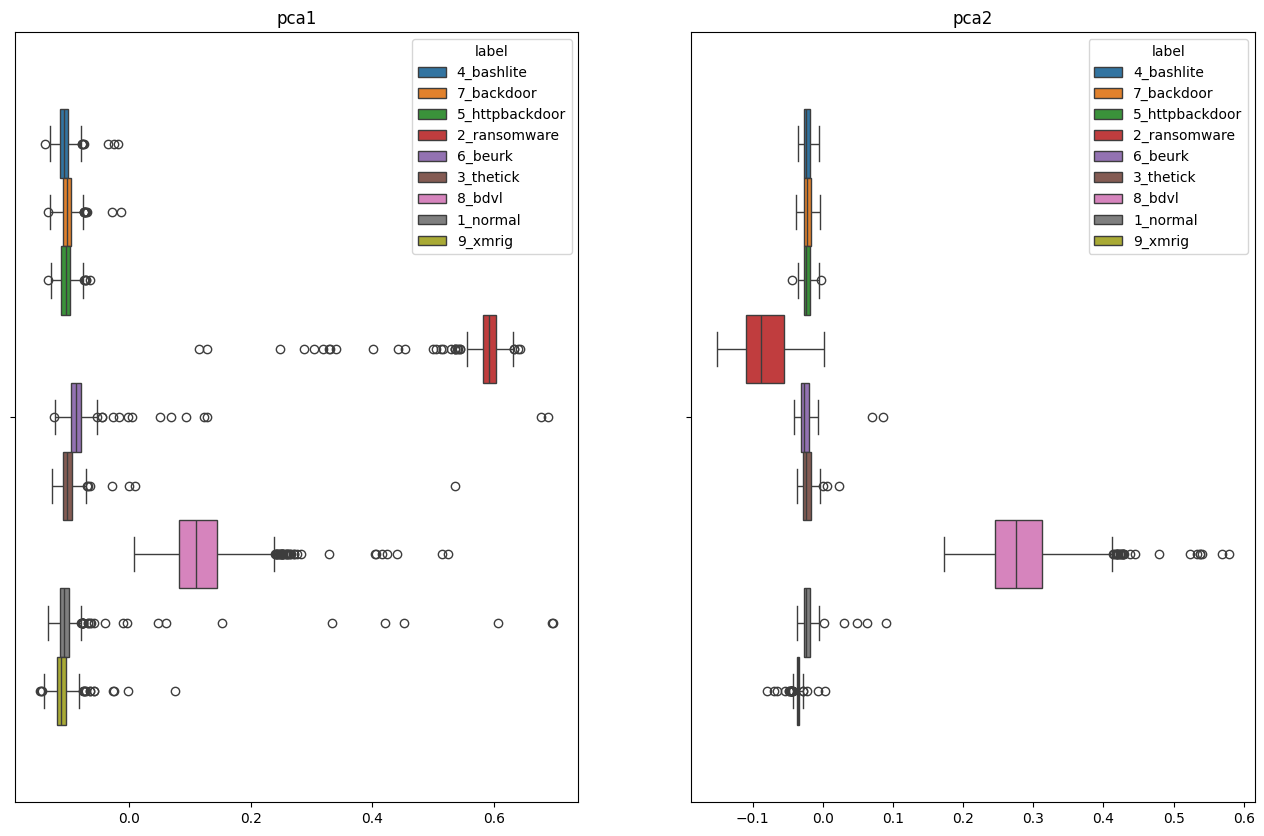

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

axs = axs.flatten()


for i, column in enumerate(df_pca.columns):
    if column == "label" or column == "timestamp":
        continue

    sns.boxplot(data=df_pca, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.show()